# nwb-photostim tutorial

In the following tutorial, we demonstrate use of the `nwb-photostim` extension to the NWB data standard. Specifically we:
1. Create `SpatialLightModulator` and `PhotostimulationDevice` containers, representing the devices used in the paradigm.
2. Use the `HolographicPattern` object to store the photostimulation stimuli
3. Record the time series of stimulus presentation with the `PresentationSeries` container
4. Record all photostimulation data for a given experiment using a proecessing module and the `PresentationTable` container
5. Write all devices, stimuli, and presentation tables to an `.nwb` file and confirm it can be read back

First, we import then necessary files and create an empty `NWBFile`.

In [1]:
from pynwb import NWBFile, NWBHDF5IO
from ndx_photostim import SpatialLightModulator, PhotostimulationDevice, HolographicPattern, PhotostimulationSeries, PhotostimulationTable
import numpy as np
from dateutil.tz import tzlocal
from datetime import datetime

nwbfile = NWBFile('my first synthetic recording','EXAMPLE_ID',datetime.now(tzlocal()))

## Spatial light modulator

We begin by creating an optional `SpatialLightModulator` container, to represent the spatial light modulator used in the stimulation paradigm.

In [2]:
slm = SpatialLightModulator(name="slm", size=np.array([1, 2, 3]))

## PhotostimulationDevice

We can then add this to a `PhotostimulationDevice` using the `add_slm` method. Alternatively, we can specify the SLM as an input argument to the constructor via `slm=...`.

In [3]:
photostim_dev = PhotostimulationDevice(name="photostim_dev", description="photostim_device",
                                       type='LED', wavelength=320,  opsin='test_opsin',
                                       peak_pulse_energy=20, power=10, pulse_rate=5)
photostim_dev.add_slm(slm)
nwbfile.add_device(photostim_dev)

photostim_dev file_classes.PhotostimulationDevice at 0x140527585776288
Fields:
  description: photostim_device
  opsin: test_opsin
  peak_pulse_energy: 20
  power: 10
  pulse_rate: 5
  slm: slm file_classes.SpatialLightModulator at 0x140527585773024
Fields:
  size: [1 2 3]

  type: LED
  wavelength: 320

## Holographic stimulation pattern

The container `HolographicPattern` is used to store data corresponding to the pattern of stimulation for a given trial. The primary
input to the function is a set of ROIs, that denote whether a given pixel is stimulated (encoded as 1) or not stimulated (encoded as 0)
when that stimulus is presented. There are two ways to specify the ROIs: as an `image_mask_roi` or a `pixel_roi` (described below).

### ROIs specified using an image mask

In the `image_mask_roi`, the input to `HolographicPattern` is an array or list with dimensionality `[width, height]` or `[width, height, depth`] covering the entire field of view. ROIs that are stimulated are encoded by 1 values, and unstimulated regions by zeros.

In the example below, we simulate a `[50, 50]` pixel field of view, and randomly select 5 ROIs with a width and height of 5 pixels. To store the pattern in a `HolographicPattern` object, we use specify the ROIs using the `mask_roi` input argument on construction. A helper method `show_mask()` shows the simulated stimulated regions.

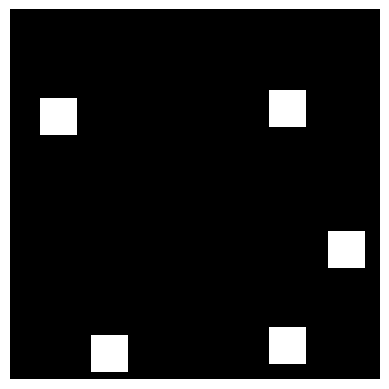

In [4]:
image_mask_roi = np.zeros((50, 50))

n_rois = 5
for _ in range(n_rois):
    x = np.random.randint(0, 45)
    y = np.random.randint(0, 45)
    image_mask_roi[x:x + 5, y:y + 5] = 1

hp_1 = HolographicPattern(name='pattern 1', image_mask_roi=image_mask_roi)
hp_1.show_mask()

### ROIs specified by the center and diameter of each region

Additionally, we provide a second method for specifying ROIs, the `pixel_roi`. `pixel_roi` inputs are a two- or three-dimensional vector of size `[num_rois, 3]` (in 2D stimulation) or `[num_rois, 4]` (in 3D stimulation). In the 2D case, `pixel_roi` takes the form `[(x1, y1), (x2, y2), ...]`, where `x` and `y` values correspond with the center of the ROI (in pixels). Similarly, in the 3D case, each element in the input takes the form `(x, y, z)`, where `z` denotes the depth of stimulation.

As compared to `image_mask_roi`, `pixel_roi` construction require two additional specifications: `stimulation_diameter` and `dimension`. `stimulation_diameter` denotes, in pixels, the radius of the ROI centered at input location `(x, y)` or `(x, y, z)`. That is, each row of `pixel_roi` corresponds to an ROI at a given location, extending `stimulation_diameter` pixels in every direction. Additionally, the dimensions of the field of view, in pixels, must be specified by the `dimension` parameter, where `dimension=[width, height]` or `[width, height, depth]`.

An example of a `HolographicPattern` with a `pixel_roi` input is shown below. This example includes 5 randomly-selected ROIs in a `[100, 100]` field of view, with a `stimulation_diameter` of 8 pixels. We use the helper function `show_mask()` to visualize the pattern.

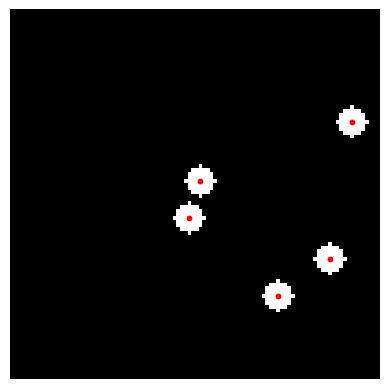

In [5]:
pixel_roi = []

for i in range(5):
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    for ix in range(x, x + 1):
        for iy in range(y, y + 1):
            pixel_roi.append((ix, iy))

hp_2 = HolographicPattern(name='pattern 2', pixel_roi=pixel_roi, roi_size=8, dimension=[100, 100])
hp_2.show_mask()

Alternatively, ROIs can also be specified as rectangles (2D) or cuboids (3D) via two- or three-dimensional `roi_size` inputs, with format `[width, height]` or `[width, height, depth]`.

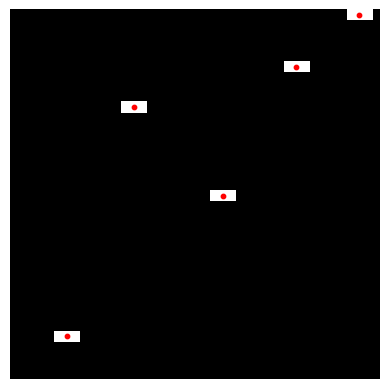

In [6]:
pixel_roi = []

for i in range(5):
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    for ix in range(x, x + 1):
        for iy in range(y, y + 1):
            pixel_roi.append((ix, iy))

hp_2 = HolographicPattern(name='pattern 2', pixel_roi=pixel_roi, roi_size=[6, 2], dimension=[100, 100])
hp_2.show_mask()

## Stimulation series

The presentation of a given stimulation pattern over time is stored via the `PhotostimulationSeries` container.



### Interval format

In the `'interval'` format, we store the onset and cessation of stimulus presentation using a 1D array consisting of the values 1 (stimulus on) and -1 (stimulus off). The corresponding times for the start and stop of the stimulus are specified via the `timestamps` property, where `data[i]==1` denotes that the stimulus was presented at time `timestamps[i]`, and `data[i+1]==-1` denotes it stopped at time `timestamps[i+1]` (time is specified in seconds). For example, in the cell below, we note that pattern `hp_1` was presented from seconds `0.5` to `1`, and then again from seconds `2` to `4`.

In [7]:
stim_series_1 = PhotostimulationSeries(name="series_1", format='interval', data=[1, -1, 1, -1],
                                       timestamps=[0.5, 1, 2, 4], pattern=hp_1,
                                       stimulus_method="stim_method", sweep_pattern="...",
                                       time_per_sweep=10, num_sweeps=20)

While we can specify the `data` and `timestamps` directly, we can also initialize an empty `PhotostimulationSeries` (by not providing a `data` or `timestamps` input), and use the function `add_interval(start, stop)` to store the presentation of the stimulus from time `start` to time `stop`. In the example below, the first call indicates presentation of the stimulus between seconds `10` and `20`, and then again from seconds `35` to `40`. We can call the helper method `to_dataframe()` to display `data` and `timestamps` simultaneously.

In [8]:
stim_series_2 = PhotostimulationSeries(name="series_2", format='interval',  pattern=hp_2)
stim_series_2.add_interval(10., 20.)
stim_series_2.add_interval(35., 40.)

print(stim_series_2.to_dataframe())

   data  timestamps
0     1        10.0
1    -1        20.0
2     1        35.0
3    -1        40.0


### Series format

In addition to the interval format, we can also encode presentation time series data as a "series." In this format, rather than indicating the start and stop of stimulation,`data` consists of a 1D array of 0s and 1s denoting whether a stimulus was on or off at a given time step. In the example below, we note that the data is `[0, 1, 0, 1, 1, 0]`, the rate (i.e., the rate at which data are sampled, in Hz) is `10`, and the `stimulus_duration` is `0.05` (meaning that, at each time point where the stimulus is "on", denoted by a value of 1, it remains on for 0.05 seconds). In the case of the fourth element (`data[3]=1`), for example, the `rate` indicates that this point corresponds to 0.4 seconds into the trial (since `rate=10`, meaning there are 10 evenly-sampled data points per second). Since the value of the element is `1`, the stimulus was presented at that time, for `stimulus_duration=0.05` seconds. Expressed as an interval, the fourth time step indicates the stimulus was presented from *t*=0.4 to *t=0.05*.

While less easily interpretable, we include `format='series'` as an option for the time series format because it may more closely align with the data collection modalities used in photostimulation methods.

In [9]:
stim_series_3 = PhotostimulationSeries(name="series_3", pattern=hp_1, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1, 1, 0], rate=10.)
print(stim_series_3.to_dataframe())

   data  timestamps
0     0         0.0
1     1         0.1
2     0         0.2
3     1         0.3
4     1         0.4
5     0         0.5


In the example above, we use the `rate` parameter instead of `timestamps` to express the times `data` correspond to. In the `'series'` format, we can still specify timestamps directly, as we did for the interval series. Here, the data `data[i]` corresponds to an interval beginning at time `timestamps[i]` and ending at time `timestamps[i]+stimulus_duration`. Note that `PhotostimulationSeries` requires one of either `rate` or `timestamps` to be specified for the series format, in order for data to be added.

In addition to adding data directly, we can also add data using the `add_onset(time)` method, which denotes the onset of the stimulus at time `time` (for duration `stimulus_duration`).

In [10]:
stim_series_4 = PhotostimulationSeries(name="series_4", pattern=hp_2, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1], timestamps=[0, 0.5, 2, 4])
stim_series_4.add_onset(5)
stim_series_4.add_onset([10, 14, 50])
print(stim_series_4.to_dataframe())

   data  timestamps
0     0         0.0
1     1         0.5
2     0         2.0
3     1         4.0
4     1         5.0
5     1        10.0
6     1        14.0
7     1        50.0


The `add_onset` function also works for the `'interval'` format:

In [11]:
stim_series_5 = PhotostimulationSeries(name="series_5", format='interval', pattern=hp_1, stimulus_duration=2)
stim_series_5.add_onset(1)
stim_series_5.add_onset([10, 18, 24])
print(stim_series_5.to_dataframe())

   data  timestamps
0     1           1
1    -1           3
2     1          10
3    -1          12
4     1          18
5    -1          20
6     1          24
7    -1          26


We then have to add each stimulus to the NWB file (to prevent parent/child errors below).

In [12]:
for stim in [stim_series_1, stim_series_2, stim_series_3, stim_series_4, stim_series_5]:
    nwbfile.add_stimulus(stim)

## PhotostimulationTable

We store all the series and associated metadata for a given experiment in a `PhotostimulationTable`. The table constructor table takes as inputs the device used in simulation (`photostimulation_device`), as well as optional collection parameters (`stimulus_method`, `sweep_pattern`, `time_per_sweep` and `num_sweeps`). To add the `PhotostimulationSeries` containers, we call the `add_series` function, specifying a list of `PhotostimulationSeries` objects, as well as an optional list of names for each row. To display the table contents, we call the function `to_dataframe()` on the table.

In [13]:
sp = PhotostimulationTable(name='test', description='test desc', device=photostim_dev)
sp.add_series(series=[stim_series_1, stim_series_2, stim_series_3, stim_series_4, stim_series_5], row_name=['row_0', 'row_1', 'row_2', 'row_3', 'row_4'])
print(sp.to_dataframe())

   row_name                                             series series_name  \
id                                                                           
0     row_0  series_1 file_classes.PhotostimulationSeries a...    series_1   
1     row_1  series_2 file_classes.PhotostimulationSeries a...    series_2   
2     row_2  series_3 file_classes.PhotostimulationSeries a...    series_3   
3     row_3  series_4 file_classes.PhotostimulationSeries a...    series_4   
4     row_4  series_5 file_classes.PhotostimulationSeries a...    series_5   

   series_format  num_samples  start_time  stop_time pattern_name  
id                                                                 
0       interval            4         0.0       4.00    pattern 1  
1       interval            4         0.0      40.00    pattern 2  
2         series            6         0.0       0.25    pattern 1  
3         series            8         0.0      50.00    pattern 2  
4       interval            8         0.0    

### Plotting PhotostimulationTable timestamps

The timestamps for each series in the `PhotostimulationTable` can be plotted simultaneously using the visualization function `plot()`.

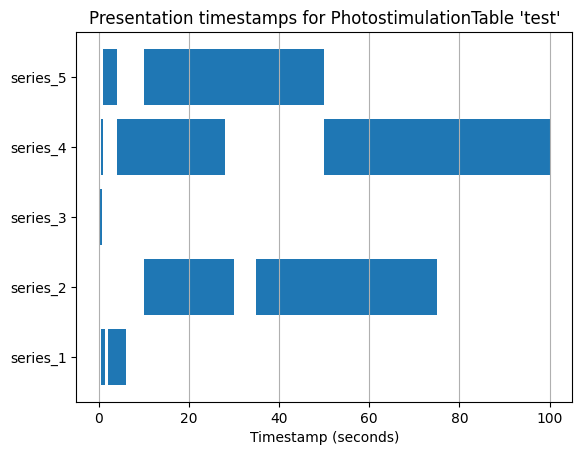

In [14]:
sp.plot_presentation_times()

### Creating a photostimulation processing module

We then save the table to an `NWBFile` by creating a processing module, as shown below.

In [15]:
module = nwbfile.create_processing_module(name="photostimulation", description="example photostimulation table")
module.add(sp)

test file_classes.PhotostimulationTable at 0x140526907534896
Fields:
  colnames: ['row_name' 'series' 'series_name' 'series_format' 'num_samples'
 'start_time' 'stop_time' 'pattern_name']
  columns: (
    row_name <class 'hdmf.common.table.VectorData'>,
    series <class 'hdmf.common.table.VectorData'>,
    series_name <class 'hdmf.common.table.VectorData'>,
    series_format <class 'hdmf.common.table.VectorData'>,
    num_samples <class 'hdmf.common.table.VectorData'>,
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    pattern_name <class 'hdmf.common.table.VectorData'>
  )
  description: test desc
  device: photostim_dev file_classes.PhotostimulationDevice at 0x140527585776288
Fields:
  description: photostim_device
  opsin: test_opsin
  peak_pulse_energy: 20
  power: 10
  pulse_rate: 5
  slm: slm file_classes.SpatialLightModulator at 0x140527585773024
Fields:
  size: [1 2 3]

  type: LED
  wavelength: 320

  id: id <class

## Writing the file

We can then write `nwbfile` file to an `.nwb` file as follows:

In [16]:
with NWBHDF5IO("photostimulation_tutorial.nwb", "w") as io:
    io.write(nwbfile)

/Users/harriscaw/opt/anaconda3/envs/nwb-photostim/lib/python3.10/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'PhotostimulationSeries/timestamps': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)


## Reading the file

We can then check that the file was saved correctly by reading it back, and accessing the "`photostimulation`" processing module.

In [17]:
with NWBHDF5IO("basics_tutorial.nwb", "r", load_namespaces=True) as io:
    read_nwbfile = io.read()
print(read_nwbfile)
print(read_nwbfile.processing['holographic_photostim'])

root pynwb.file.NWBFile at 0x140526640823360
Fields:
  devices: {
    photostim_dev <class 'file_classes.PhotostimulationDevice'>
  }
  file_create_date: [datetime.datetime(2022, 11, 10, 16, 36, 45, 878851, tzinfo=tzoffset(None, -18000))]
  identifier: EXAMPLE_ID
  processing: {
    holographic_photostim <class 'pynwb.base.ProcessingModule'>
  }
  session_description: my first synthetic recording
  session_start_time: 2022-11-10 16:36:45.878677-05:00
  stimulus: {
    series1 <class 'file_classes.PhotostimulationSeries'>,
    series2 <class 'file_classes.PhotostimulationSeries'>,
    series3 <class 'file_classes.PhotostimulationSeries'>
  }
  timestamps_reference_time: 2022-11-10 16:36:45.878677-05:00

holographic_photostim pynwb.base.ProcessingModule at 0x140526907996144
Fields:
  data_interfaces: {
    test <class 'file_classes.PhotostimulationTable'>
  }
  description: initial data

